In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

def safelog2(x):
    if x == 0:
        return(0)
    else:
        return(np.log2(x))

## Importing Data

In [2]:
data_set = np.genfromtxt("hw05_data_set.csv", delimiter = ",",skip_header=1) # skip header

X = data_set[0:,0]
y = data_set[0:,1]

N = X.shape[0]

# get train and test splits
train_indices = np.arange(0, 150) # 150 data points to the training 
test_indices = np.setdiff1d(range(N), train_indices)

x_train = X[train_indices,]
y_train = y[train_indices,]
x_test = X[test_indices,]
y_test = y[test_indices,]

N_train = train_indices.shape[0]
N_test = test_indices.shape[0]

## Initialization

In [3]:
# create necessary data structures
node_indices = {}
is_terminal = {}
need_split = {}

node_features = {} # not needed since we do not show tree
node_splits = {}

# put all training instances into the root node
node_indices[1] = np.array(range(N_train))
is_terminal[1] = False
need_split[1] = True

## Tree Inference

In [4]:
# learning algorithm
def learnTree(prePrunningParam):
    while True:
        # find nodes that need splitting
        split_nodes = [key for key, value in need_split.items() if value == True]
        # check whether we reach all terminal nodes
        if len(split_nodes) == 0:
            break
        # find best split positions for all nodes
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            if data_indices.shape[0] <= prePrunningParam: #check the pre-pruning parameter P
                is_terminal[split_node] = True
            else:
                is_terminal[split_node] = False
                best_scores = 0.0
                best_splits = 0.0
                unique_values = np.sort(np.unique(x_train[data_indices]))
                split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                # no iteration for number of Feature(D)
                for s in range(len(split_positions)):
                    left = np.sum((x_train[data_indices] < split_positions[s]) * y_train[data_indices]) / np.sum((x_train[data_indices] < split_positions[s]))
                    right = np.sum((x_train[data_indices] >= split_positions[s]) * y_train[data_indices]) / np.sum((x_train[data_indices] >= split_positions[s]))
                    split_scores[s] = 1 / len(data_indices) * (np.sum((y_train[data_indices]-np.repeat(left, data_indices.shape[0], axis = 0))**2 * (x_train[data_indices] < split_positions[s])) + np.sum((y_train[data_indices] - np.repeat(right, data_indices.shape[0], axis = 0))**2 * (x_train[data_indices] >= split_positions[s])))
                
                best_scores = np.min(split_scores)
                best_splits = split_positions[np.argmin(split_scores)]

                node_splits[split_node] = best_splits
                # create left node using the selected split
                left_indices = data_indices[x_train[data_indices] < best_splits]
                node_indices[2 * split_node] = left_indices
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True

                # create right node using the selected split
                right_indices = data_indices[x_train[data_indices] >= best_splits]
                node_indices[2 * split_node + 1] = right_indices
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True
                
                #print(node_splits)

In [5]:
prePrunningParam=25
learnTree(prePrunningParam)

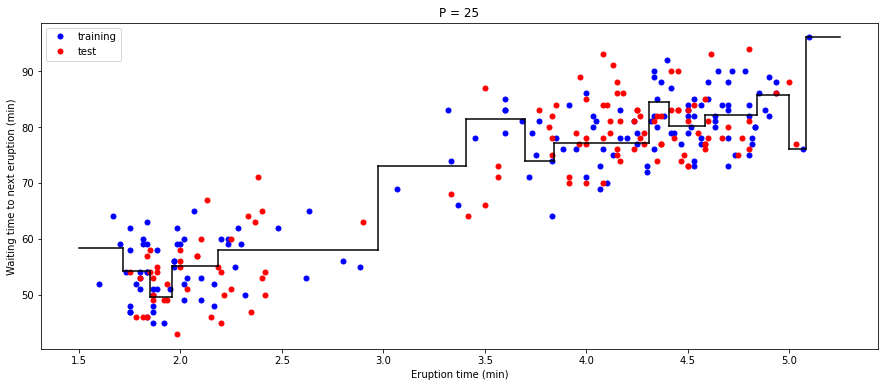

In [6]:
minimum_value = 1.5
maximum_value = 5.25
node_split_values = np.sort(np.array(list(node_splits.items()))[:,1])
left_borders = np.append(minimum_value, np.transpose(np.sort(np.array(list(node_splits.items()))[:,1])))
right_borders = np.append(np.transpose(np.sort(np.array(list(node_splits.items()))[:,1])), maximum_value)

p_hat = np.asarray([np.sum(((left_borders[b] < x_train) & (x_train <= right_borders[b])) * y_train) for b in range(len(left_borders))]) / np.asarray([np.sum((left_borders[b] < x_train) & (x_train <= right_borders[b])) for b in range(len(left_borders))])

plt.figure(figsize = (15, 6))
plt.title("P = 25")
plt.xlabel("Eruption time (min)")
plt.ylabel("Waiting time to next eruption (min)")
plt.plot(x_train, y_train, "b.", label = 'training', markersize = 10)
plt.plot(x_test, y_test, "r.", label = 'test', markersize = 10)
plt.legend(loc = "upper left")
for b in range(len(left_borders)):
    plt.plot([left_borders[b], right_borders[b]], [p_hat[b], p_hat[b]], "k-")
for b in range(len(left_borders) - 1):
    plt.plot([right_borders[b], right_borders[b]], [p_hat[b], p_hat[b + 1]], "k-")
plt.show()

In [7]:
def calculateRMSE(N,x,y,p_hat):    
    sum_regress = 0
    for i in range(N):
        for a in range(len(left_borders)):
            if (left_borders[a] < x[i]) and (x[i] <= right_borders[a]):
                sum_regress += (y[i] - p_hat[a])**2
    rmse_regress = math.sqrt(sum_regress/N)
    return(rmse_regress)

In [8]:
print("RMSE on training set is", calculateRMSE(N_train,x_train,y_train,p_hat), "when P is 25")
print("RMSE on test set is", calculateRMSE(N_test,x_test,y_test,p_hat), "when P is 25")

RMSE on training set is 4.541214189194451 when P is 25
RMSE on test set is 6.454083413352087 when P is 25


In [9]:
P_values_train = []
P_values_test = []
rmse_values_train = []
rmse_values = []
for p in range(5,55,5): #pre-pruning parameter P to 5,10..50
    node_indices = {}
    is_terminal = {}
    need_split = {}

    node_features = {} # not needed since we do not show tree
    node_splits = {}

    node_indices[1] = np.array(range(N_train))
    is_terminal[1] = False
    need_split[1] = True
    learnTree(p) # learning tree with different pre-pruning parameters
    
    node_split_values = np.sort(np.array(list(node_splits.items()))[:,1])
    left_borders = np.append(minimum_value, np.transpose(np.sort(np.array(list(node_splits.items()))[:,1])))
    right_borders = np.append(np.transpose(np.sort(np.array(list(node_splits.items()))[:,1])), maximum_value)
    p_hat = np.asarray([np.sum(((left_borders[b] < x_train) & (x_train <= right_borders[b])) * y_train) for b in range(len(left_borders))]) / np.asarray([np.sum((left_borders[b] < x_train) & (x_train <= right_borders[b])) for b in range(len(left_borders))])
    
    rmse_regress_train = calculateRMSE(N_train,x_train,y_train,p_hat)
    P_values_train.append(p)
    rmse_values_train.append(rmse_regress_train)
    
    rmse_regress = calculateRMSE(N_test,x_test,y_test,p_hat)
    P_values_test.append(p)
    rmse_values.append(rmse_regress)

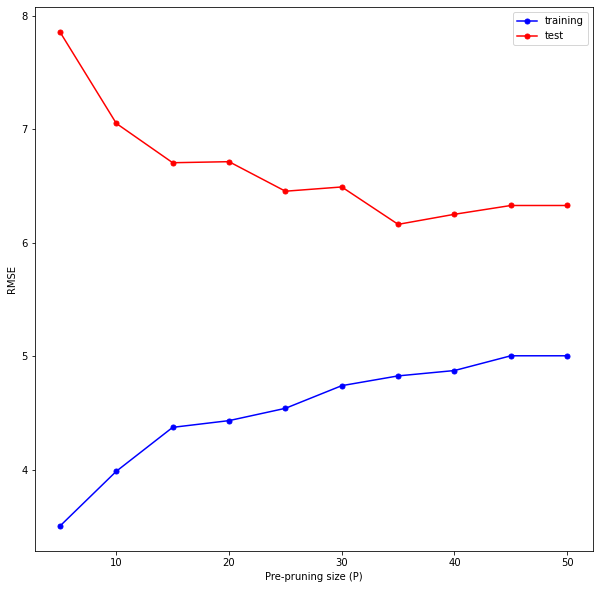

In [10]:
plt.figure(figsize = (10, 10))
#print(rmse_values_train)
plt.plot(P_values_train, rmse_values_train, marker = ".", markersize = 10, linestyle = "-", color = "b",label='train')
plt.plot(P_values_test, rmse_values, marker = ".", markersize = 10, linestyle = "-", color = "r",label='test')
plt.xlabel("Pre-pruning size (P)")
plt.ylabel("RMSE")
plt.legend(['training', 'test'])
plt.show()